# Logistic Regression Model
## Model 1

# Imports 

In [197]:
# Imports
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [198]:
# Import change_summary
changelog = pd.read_csv('../Changelogs/change_summary.csv').to_dict(orient='records')

# Change summary intialization and check
change_summary = pd.DataFrame(changelog)
pd.set_option('display.max_colwidth', None)
display(change_summary)  

,column,change,rationale
0,age,Removed 3 row(s) where age > 125,Oldest verified human lived to be 122; values above 125 are likely errors or outliers.
1,loan_status,Dropped loan_status column,Target variable for classification; not needed in cleaned dataset.
2,person_income,"Capped person_income at $3,000,000 and applied log1p transformation",Handled extreme right skew and outliers in income distribution; log1p applied to normalize values and removed person_income for modeling.
3,loan_amnt,Applied log1p transformation to loan_amount,Handled extreme right skew and outliers in loan amount distribution; log1p applied to normalize values.
4,person_emp_exp,Removed 5 row(s) where person_emp_exp > 70,Unrealistic employment experience; values above 70 years are likely errors or outliers.
5,numerical_columns,Scaled numerical columns using MinMaxScaler,"Normalized numerical features to a range of [0, 1] for better model performance."
6,"['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']","Removed 117 row(s) containing ""unknown"" values","""unknown"" adds noise and uncertainty in modeling categorical variables"
7,"['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']",Applied one-hot encoding (drop_first=True),Converted categorical variables into binary indicators for model compatibility.
8,loan_status,Readded loan_status column,Target variable for classification; readded after cleaning and preprocessing.


# Data Prep

In [199]:
# Load cleaned data from CSV
df = pd.read_csv("../Data/cleaned_loan_data.csv")
df.head()

,person_age,person_emp_exp,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,log_income,log_loan_amt,person_gender_male,person_education_Bachelor,...,person_education_Master,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes,loan_status
0,0.031250,0.000000,0.727023,0.742424,0.035714,0.434010,0.383734,1.000000,0,0,...,1,0,1,0,0,0,1,0,0,1
1,0.015625,0.000000,0.392318,0.121212,0.000000,0.289340,0.074890,0.162992,0,0,...,0,1,0,1,0,0,0,0,1,0
2,0.078125,0.048387,0.510974,0.666667,0.035714,0.621827,0.077095,0.564245,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.046875,0.000000,0.672840,0.666667,0.000000,0.723350,0.401728,1.000000,0,1,...,0,0,1,0,0,1,0,0,0,1
4,0.062500,0.016129,0.606996,0.803030,0.071429,0.497462,0.369016,1.000000,1,0,...,1,0,1,0,0,1,0,0,0,1


In [200]:
# Split the data into features and target variable
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (31412, 21)
X_test: (13463, 21)


# Models


In [202]:
# Logistic Regression
lrBase = LogisticRegression(max_iter=1000)
lrBase.fit(X_train, y_train)
y_pred = lrBase.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.7858575354675779
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.88     10471
           1       0.62      0.09      0.16      2992

    accuracy                           0.79     13463
   macro avg       0.71      0.54      0.52     13463
weighted avg       0.75      0.79      0.72     13463



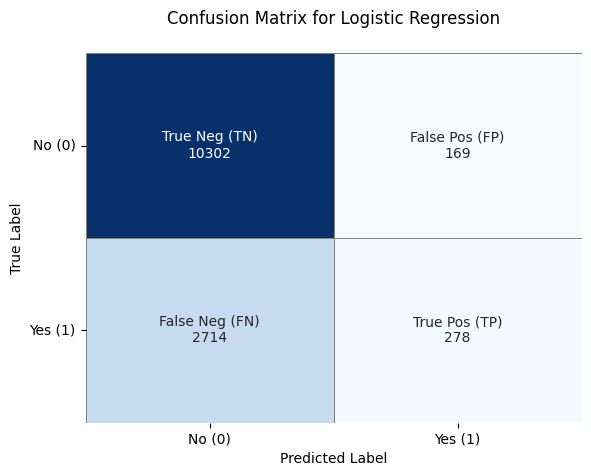

In [203]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Annotating since I forget which is which most times
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

In [204]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Combine into new balanced DataFrame
df_balanced = pd.concat(
    [pd.DataFrame(X_train, columns=X.columns),
     pd.Series(y_train, name='loan_status')],
    axis=1
)


# SMOTE changelog entry
changelog.append({
    'column': 'subscribe_to_term_deposit',
    'change': f'Resampled with SMOTE to balance target classes (shape now: {df_balanced.shape}, shape before: {df.shape})',
    'rationale': 'Used SMOTE to correct class imbalance for better model performance.',
})

In [205]:
# Train/test split on SMOTE
X_smote = df_balanced.drop(columns=['loan_status'])
y_smote = df_balanced['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)
y_smote_pred = lr_smote.predict(X_test)

lr_smote_cv_scores = cross_val_score(lr_smote, X_train_smote, y_train_smote, cv=5, scoring='accuracy')



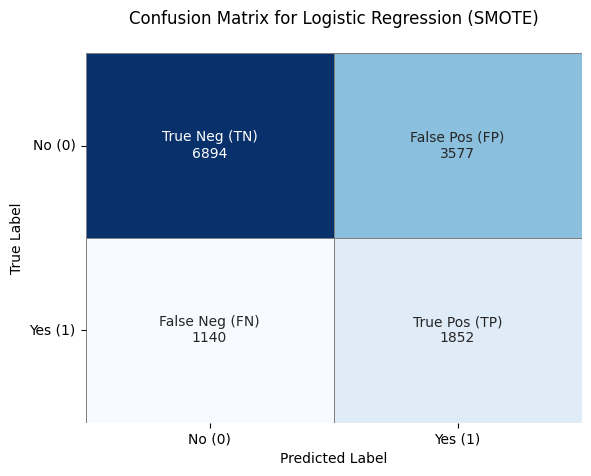

In [206]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_smote_pred)

# Define labels for annotations
group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']
group_counts = [f'{value}' for value in cm.flatten()]
labels = [f'{name}\n{count}' for name, count in zip(group_names, group_counts)]
labels = np.array(labels).reshape(2, 2)

# Plot
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression (SMOTE)\n')
plt.xticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'])
plt.yticks(ticks=[0.5, 1.5], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.show()

In [207]:
# Cross-validation for Logistic Regression
lr_cv_scores = cross_val_score(LogisticRegression(random_state=42, solver='liblinear'),
                                X_train, y_train, cv=5, scoring='accuracy')
print("\nLogistic Regression Cross-Validation Comparison:")
print(f"{'Dataset':<20}{'Mean CV Accuracy':<20}")
print(f"{'Original':<20}{lr_cv_scores.mean():<20.4f}")
print(f"{'SMOTE':<20}{lr_smote_cv_scores.mean():<20.4f}")



Logistic Regression Cross-Validation Comparison:
Dataset             Mean CV Accuracy    
Original            0.7832              
SMOTE               0.6409              


In [208]:
# Logistic Regression Hyperparameter Tuning
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train, y_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

    Rejected       0.79      0.98      0.88     10471
    Approved       0.61      0.10      0.17      2992

    accuracy                           0.79     13463
   macro avg       0.70      0.54      0.52     13463
weighted avg       0.75      0.79      0.72     13463



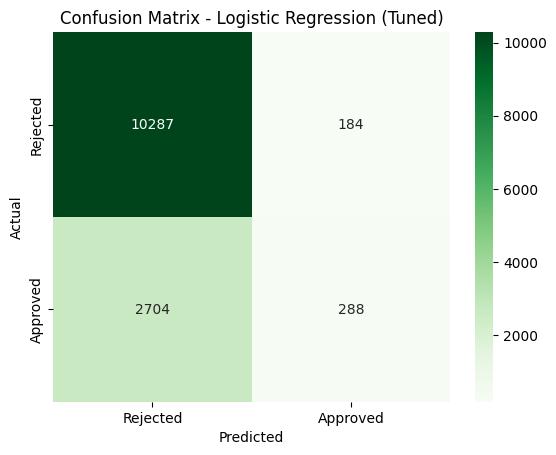

In [209]:
# Define string labels for display
target_names = ['Rejected', 'Approved'] 

# Generate predictions
lr_tuned_predictions = lr_best_model.predict(X_test)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Tuned)')
plt.show()


In [210]:
# SMOTE Logistic Regression Hyperparameter Tuning
lr_param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_grid_search = GridSearchCV(LogisticRegression(random_state=42),
                               param_grid=lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_smote_train, y_smote_train)

print("\nLogistic Regression Best Parameters:", lr_grid_search.best_params_)
lr_best_model = lr_grid_search.best_estimator_


Logistic Regression Best Parameters: {'C': 166.81005372000558, 'penalty': 'l2', 'solver': 'liblinear'}



Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     10471
           1       0.34      0.62      0.44      2992

    accuracy                           0.65     13463
   macro avg       0.60      0.64      0.59     13463
weighted avg       0.74      0.65      0.68     13463



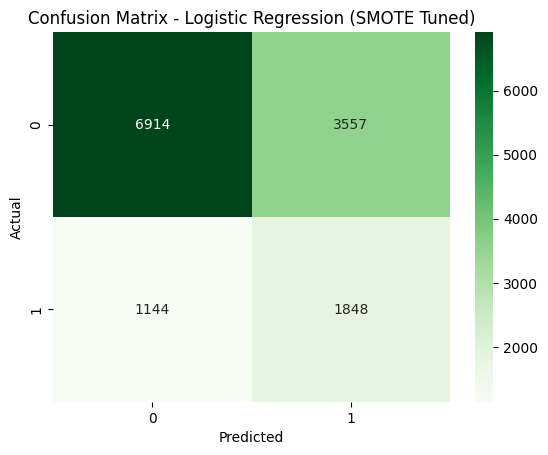

In [211]:
# Define string labels for display
target_names = ['0', '1'] 

# Generate predictions
lr_tuned_predictions = lr_best_model.predict(X_test)

# Classification report
print("\nLogistic Regression (Tuned):")
print(classification_report(y_test, lr_tuned_predictions, target_names=target_names))

# Confusion matrix
cm_lr_tuned = confusion_matrix(y_test, lr_tuned_predictions, labels=[0, 1])
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (SMOTE Tuned)')
plt.show()



--- Learning Curve ---


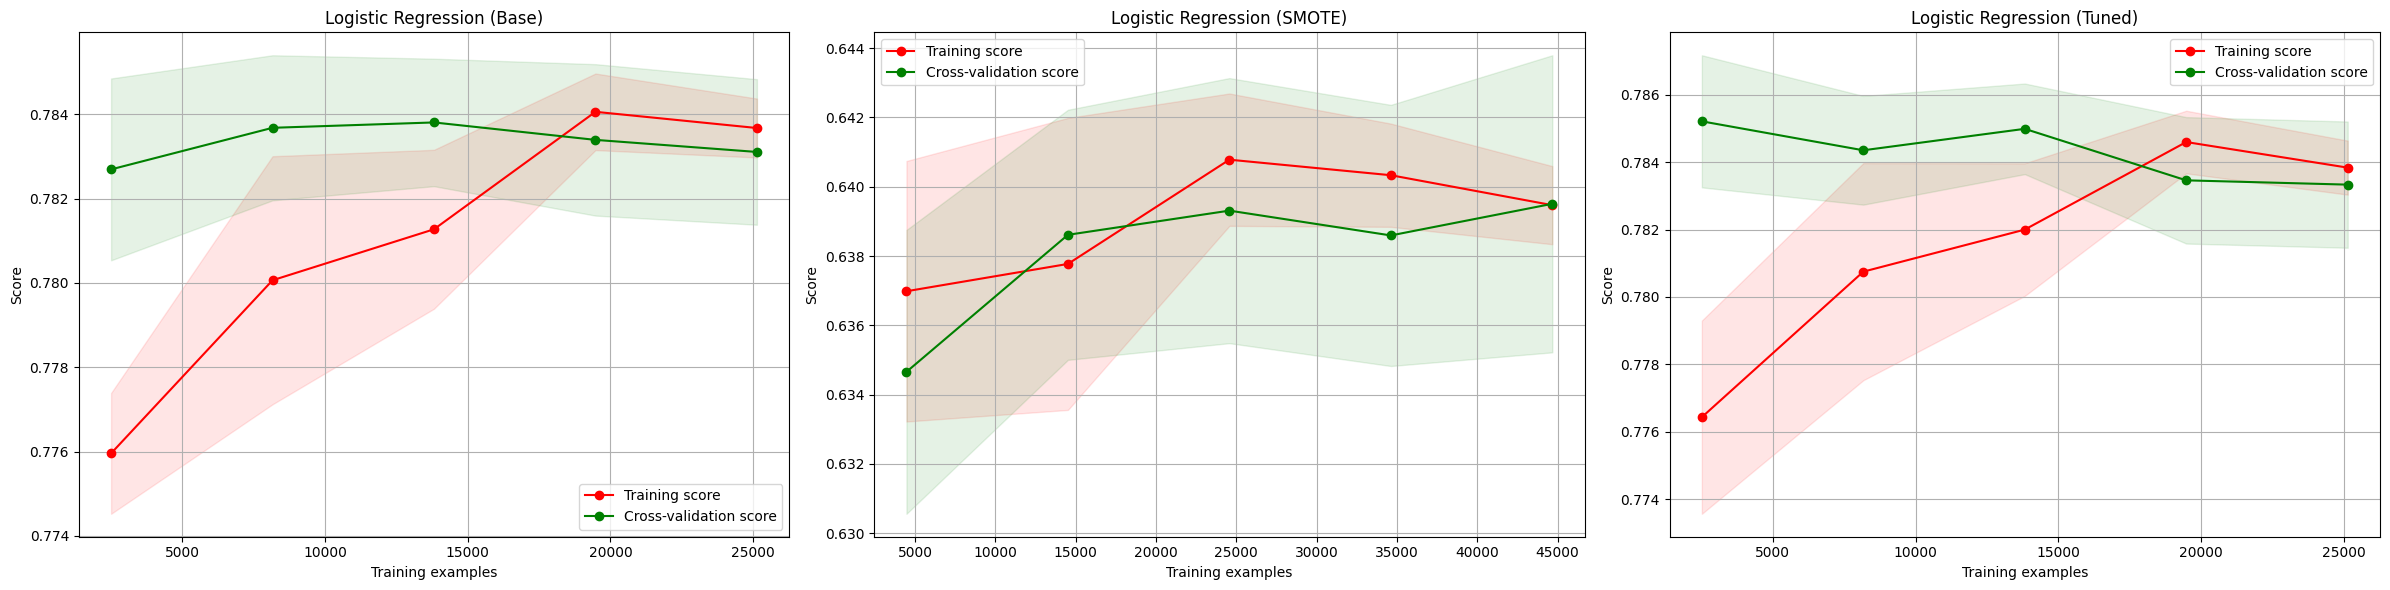

In [212]:
# --- Learning Curve ---

print("\n--- Learning Curve ---")

def plot_learning_curve(estimator, title, X, y, axes=None, train_sizes=np.linspace(0.1, 1.0, 5), cv=None, scoring='accuracy'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.legend(loc="best")
    return plt

# Plot learning curves for different models
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# Original
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (Base)", 
                    X_train, y_train, axes=axes[0], cv=5)

# SMOTE
plot_learning_curve(LogisticRegression(random_state=42), 
                    "Logistic Regression (SMOTE)", 
                    X_smote_train, y_smote_train, axes=axes[1], cv=5)

# Tuned model
plot_learning_curve(lr_best_model, 
                    "Logistic Regression (Tuned)", 
                    X_train, y_train, axes=axes[2], cv=5)

plt.tight_layout()
plt.show()



In [213]:
# --- Hyperparameter Tuning using Grid Search CV ---

print("\n--- Hyperparameter Tuning using Grid Search CV ---")

# Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 15),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 4, 5]
}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                               param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

print("\nDecision Tree Best Parameters:", dt_grid_search.best_params_)
dt_best_model = dt_grid_search.best_estimator_



--- Hyperparameter Tuning using Grid Search CV ---

Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


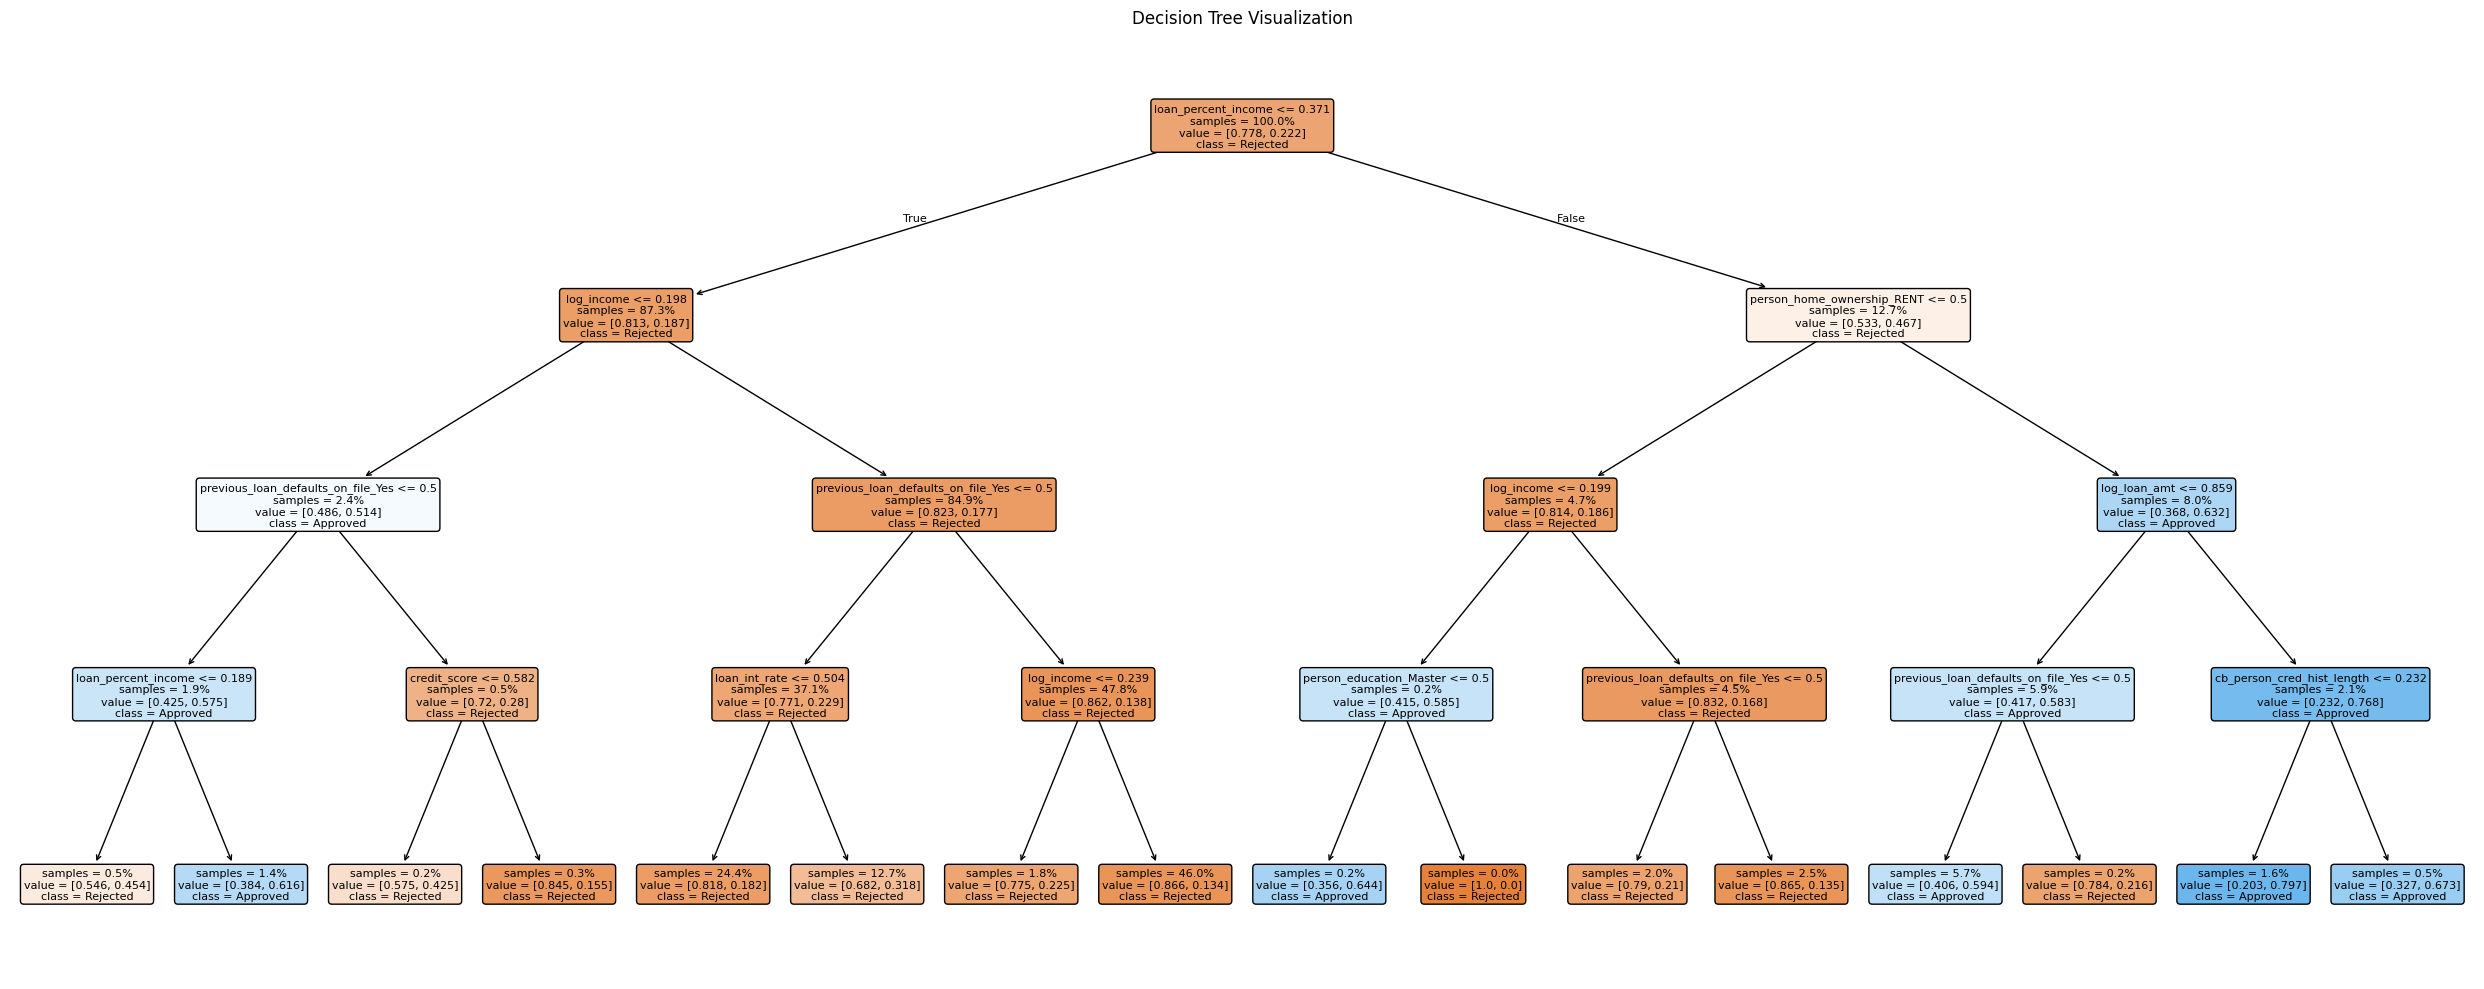

In [214]:
# Visualize the Decision Tree
plt.figure(figsize=(25, 10))
plot_tree(dt_best_model, feature_names=X_train.columns, class_names=['Rejected', 'Approved'], filled=True, fontsize=8,
          impurity=False,       
          proportion=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()